In [1]:
## Objectifs du projet

### Business Objectives (BO)
# - BO1 : Optimiser la planification des ressources système
# - BO2 : Identifier des profils d’utilisation similaires (heures/jours/météo)
#  pour adapter l’offre de vélos aux différents contextes.
# - BO3 : optimiser le ciblage des utilisateurs occasionnels et enregistrés selon leurs comportements et
#  les conditions contextuelles.

### Data Science Objectives (DSO)
# - DSO1 : **Prédire** la demande horaire (`cnt`) via un modèle de **régression**
# - DSO2 : Segmenter les créneaux horaires/jours en groupes homogènes via ACP + clustering (KMeans)
# - DSO3 : Prédire l’activité des utilisateurs et recommander les périodes et cibles marketing idéales pour
#  créer un plan de campagne annuel basé sur les prévisions et les facteurs contextuels (saison, météo, heure, jour)


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                           silhouette_score, classification_report, confusion_matrix)
import joblib



# Optional: statsmodels for SARIMAX forecasting
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    SARIMAX_AVAILABLE = True
except ImportError:
    SARIMAX_AVAILABLE = False
    print("SARIMAX not available - forecasting will be skipped")

# Configuration des chemins
DATA_PATH = 'datahour.csv'
OUT_DIR = 'outputs'
PLOT_DIR = os.path.join(OUT_DIR, 'plots')

# Créer les dossiers
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)

print("Configuration terminée")

Configuration terminée


In [3]:
df = pd.read_csv(DATA_PATH)
df['dteday'] = pd.to_datetime(df['dteday'])
print('Shape initiale:', df.shape)
display(df.head())
print(df.describe().T)
print("Missing values:\n", df.isnull().sum())

Shape initiale: (17484, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1.0,2011-01-01,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2.0,2011-01-01,1.0,0.0,1.0,1.0,0.0,6.0,NaN,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2,3.0,2011-01-01,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
3,4.0,2011-01-01,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
4,5.0,2011-01-01,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


              count         mean          std   min        25%        50%  \
instant     17131.0  8678.806666  5013.504186  1.00  4342.5000  8664.0000   
season      17103.0     2.504239     1.106255  1.00     2.0000     3.0000   
yr          17141.0     0.502596     0.500008  0.00     0.0000     1.0000   
mnth        17151.0     6.540493     3.438079  1.00     4.0000     7.0000   
hr          17120.0    11.555315     6.922491  0.00     6.0000    12.0000   
holiday     17126.0     0.028903     0.167540  0.00     0.0000     0.0000   
weekday     17130.0     3.000817     2.006237  0.00     1.0000     3.0000   
workingday  17139.0     0.683237     0.465228  0.00     0.0000     1.0000   
weathersit  17130.0     1.425803     0.639642  1.00     1.0000     1.0000   
temp        17152.0     0.497385     0.192669  0.02     0.3400     0.5000   
atemp       17118.0     0.476085     0.171818  0.00     0.3333     0.4848   
hum         17169.0     0.626772     0.192674  0.00     0.4800     0.6300   

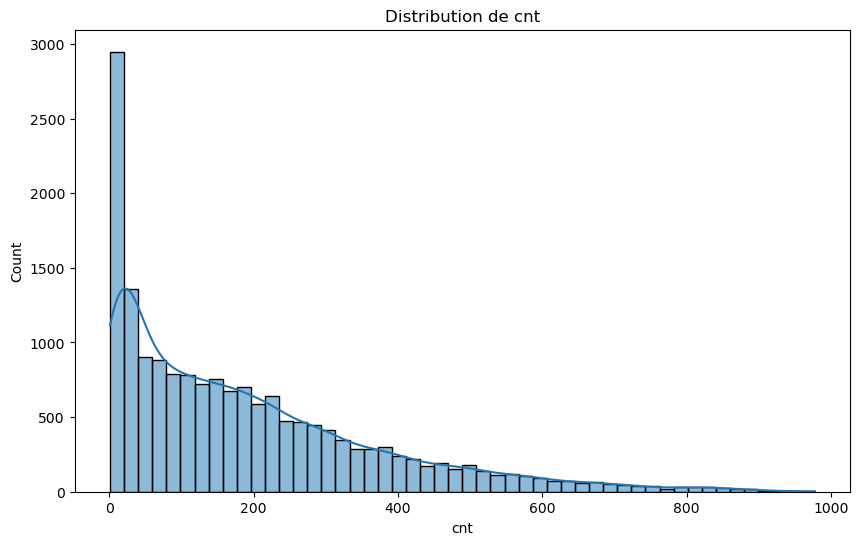

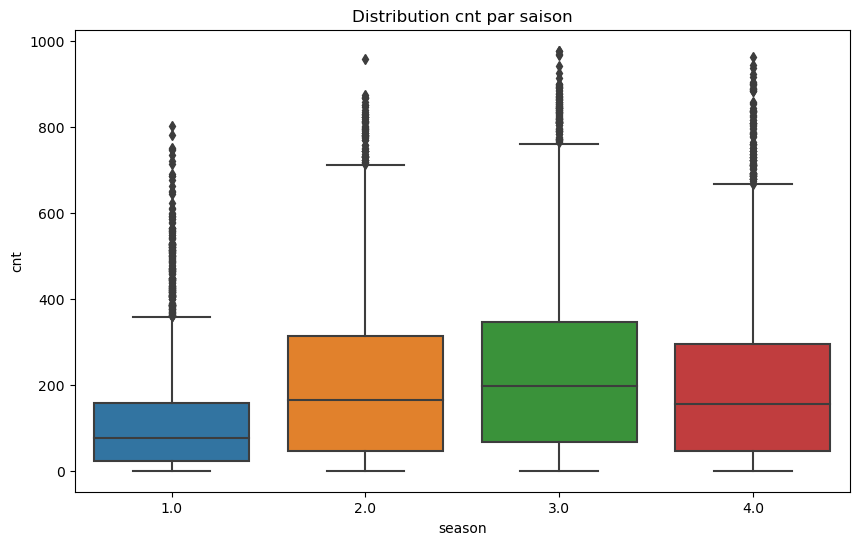

In [4]:
df = df.drop(columns=['instant','casual','registered'], errors='ignore')

# Distribution of cnt
plt.figure(figsize=(10,6))
sns.histplot(df['cnt'], bins=50, kde=True)
plt.title('Distribution de cnt')
plt.savefig(os.path.join(PLOT_DIR,'dist_cnt.png'))
plt.show()

# Boxplot by season
if 'season' in df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='season', y='cnt', data=df)
    plt.title('Distribution cnt par saison')
    plt.savefig(os.path.join(PLOT_DIR,'box_cnt_season.png'))
    plt.show()

In [5]:
# Détection des outliers avec la règle IQR
Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['cnt'] < (Q1 - 1.5*IQR)) | (df['cnt'] > (Q3 + 1.5*IQR))]
print(f"Outliers cnt (règle IQR): {len(outliers)} lignes ({len(outliers)/len(df):.2%})")
if len(outliers) > 0:
    display(outliers.head())


Outliers cnt (règle IQR): 495 lignes (2.83%)


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
5536,2011-08-23,3.0,0.0,8.0,14.0,0.0,2.0,1.0,1.0,0.72,NaN,0.30,0.0896,651.0
10358,2012-03-12,1.0,1.0,3.0,17.0,0.0,1.0,1.0,2.0,0.62,0.6212,0.38,0.4179,644.0
10382,2012-03-13,1.0,1.0,3.0,17.0,0.0,2.0,1.0,1.0,0.70,0.6364,0.37,0.1045,676.0
10383,2012-03-13,1.0,1.0,3.0,18.0,0.0,2.0,1.0,1.0,0.70,0.6364,0.34,0.2985,734.0
10397,2012-03-14,1.0,1.0,3.0,8.0,0.0,3.0,1.0,1.0,0.44,0.4394,0.82,0.0000,662.0


In [7]:
df2 = df.copy()

# Create time-based features
df2['hour'] = df2['hr']
df2['month'] = df2['mnth']
df2['is_weekend'] = df2['weekday'].isin([0,6]).astype(int)

# Cyclic encoding
df2['hr_sin'] = np.sin(2*np.pi*df2['hour']/24)
df2['hr_cos'] = np.cos(2*np.pi*df2['hour']/24)
df2['month_sin'] = np.sin(2*np.pi*df2['month']/12)
df2['month_cos'] = np.cos(2*np.pi*df2['month']/12)
df2['weekday_sin'] = np.sin(2*np.pi*df2['weekday']/7)
df2['weekday_cos'] = np.cos(2*np.pi*df2['weekday']/7)

# Temperature
if {'temp','atemp'}.issubset(df2.columns):
    df2['temp_combined'] = (df2['temp'] + df2['atemp'])/2
    df2 = df2.drop(columns=['atemp'])

# Lag features
df2['cnt_t_1'] = df2['cnt'].shift(1)
df2['cnt_t_24'] = df2['cnt'].shift(24)
df2['cnt_t_168'] = df2['cnt'].shift(168)

# Rolling averages
df2['cnt_rolling_24h'] = df2['cnt'].rolling(24).mean()
df2['cnt_rolling_7d'] = df2['cnt'].rolling(168).mean()

# Drop initial rows with NaN
df2 = df2.dropna().reset_index(drop=True)

# Final feature selection
features_final = [
    'temp_combined', 'cnt_t_1', 'cnt_t_24', 'cnt_t_168',
    'cnt_rolling_24h', 'cnt_rolling_7d',
    'hr_sin','hr_cos','month_sin','month_cos','is_weekend'
]

In [8]:
X_all = df2[features_final].copy()
y_all = df2['cnt'].copy()

# Train/test split
train_end = int(len(df2)*0.8)
X_train = X_all.iloc[:train_end]
X_test = X_all.iloc[train_end:]
y_train = y_all.iloc[:train_end]
y_test = y_all.iloc[train_end:]

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, os.path.join(OUT_DIR,'scaler.joblib'))

print("Data preparation complete.")
print("Train shape:", X_train_scaled.shape, "Test shape:", X_test_scaled.shape)

Data preparation complete.
Train shape: (328, 11) Test shape: (82, 11)


PC1: 0.4647, cumulative: 0.4647
PC2: 0.2076, cumulative: 0.6723
PC3: 0.1010, cumulative: 0.7733
PC4: 0.0829, cumulative: 0.8562
PC5: 0.0462, cumulative: 0.9024
PC6: 0.0334, cumulative: 0.9358
PC7: 0.0250, cumulative: 0.9608
PC8: 0.0187, cumulative: 0.9794
PC9: 0.0154, cumulative: 0.9948
PC10: 0.0035, cumulative: 0.9983
PC11: 0.0017, cumulative: 1.0000


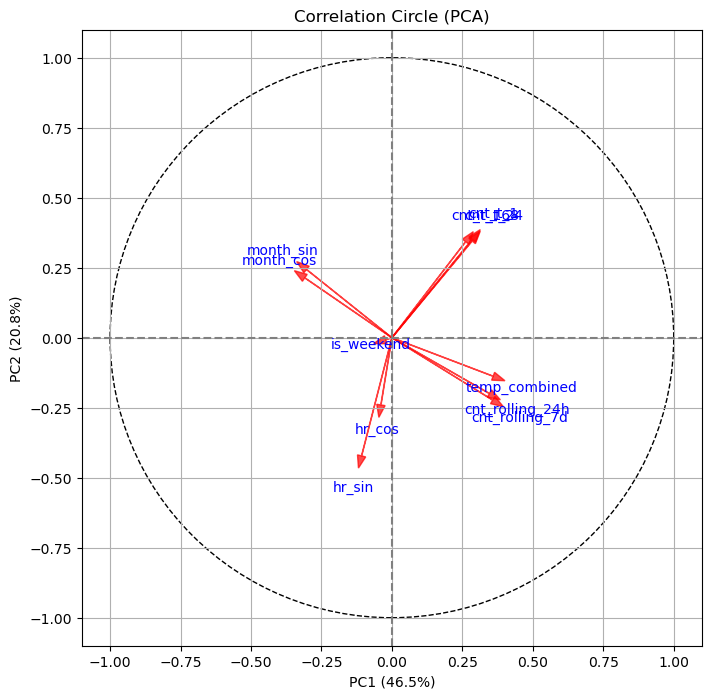

In [14]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

for i, (ev, cv) in enumerate(zip(explained_var, cumulative_var), 1):
    print(f"PC{i}: {ev:.4f}, cumulative: {cv:.4f}")

# PCA 2D for visualization
pca2 = PCA(n_components=2)
X_train_pca2 = pca2.fit_transform(X_train_scaled)

plt.figure(figsize=(8,8))
for i, feature in enumerate(features_final):
    plt.arrow(0, 0, 
              pca.components_[0, i], 
              pca.components_[1, i], 
              color='r', alpha=0.7, head_width=0.03, length_includes_head=True)
    plt.text(pca.components_[0, i]*1.15, 
             pca.components_[1, i]*1.15, 
             feature, color='b', ha='center', va='center')

# Circle for reference
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black', linestyle='--')
plt.gca().add_artist(circle)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Correlation Circle (PCA)")
plt.grid()
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.show()

Silhouette scores: {2: 0.531674762266722, 3: 0.5471333737509081, 4: 0.5221768684997333, 5: 0.45276583580428165, 6: 0.45797545623882124, 7: 0.4680786679964283, 8: 0.44681844558974054}
Optimal k: 3


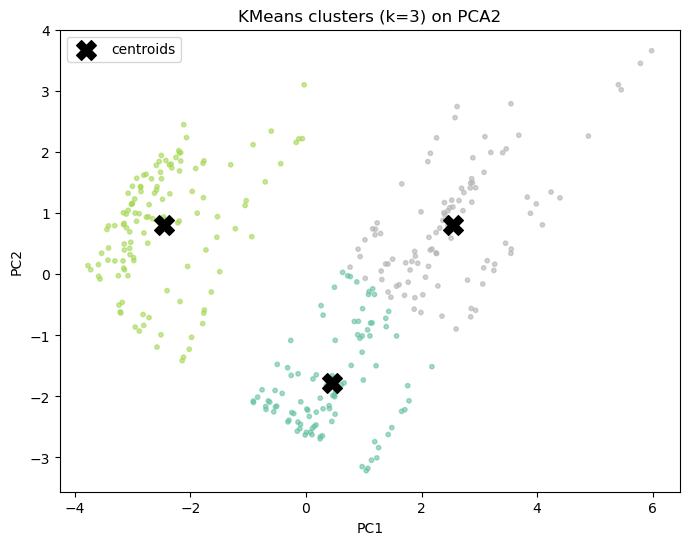

In [10]:
sil_scores = {}
data_for_cluster = X_train_pca2

for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(data_for_cluster)
    sil_scores[k] = silhouette_score(data_for_cluster, labels)

print("Silhouette scores:", sil_scores)
k_opt = max(sil_scores, key=sil_scores.get)
print("Optimal k:", k_opt)

km_final = KMeans(n_clusters=k_opt, n_init=20, random_state=42)
km_final.fit(data_for_cluster)
train_labels = km_final.labels_

# Project centroids to PCA2 space
centers2 = km_final.cluster_centers_
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=train_labels, cmap='Set2', alpha=0.6, s=10)
plt.scatter(centers2[:,0], centers2[:,1], c='black', marker='X', s=200, label='centroids')
plt.title(f'KMeans clusters (k={k_opt}) on PCA2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

RF Holdout -> RMSE: 88.504, MAE: 62.736, R2: 0.810


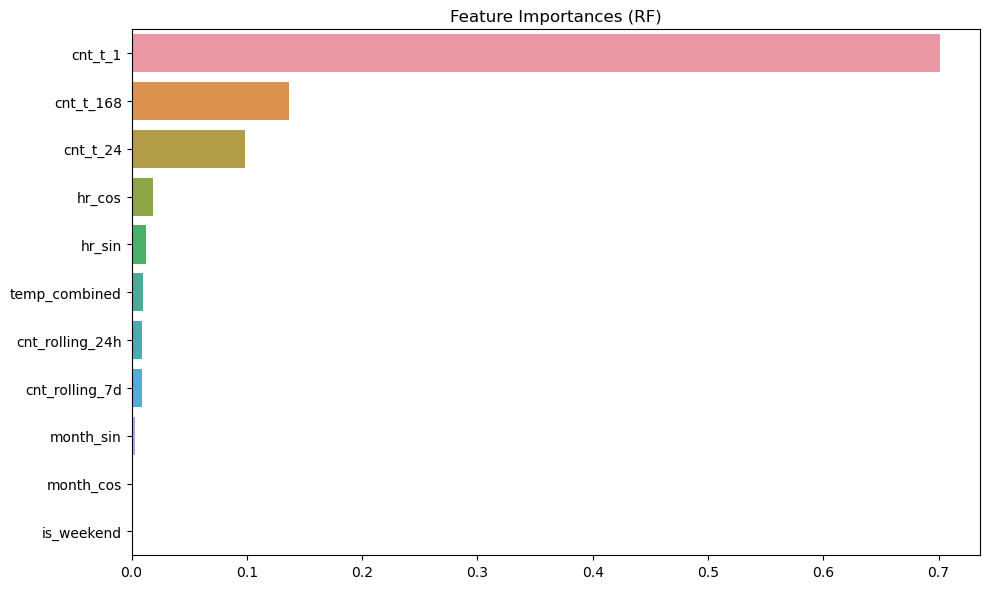

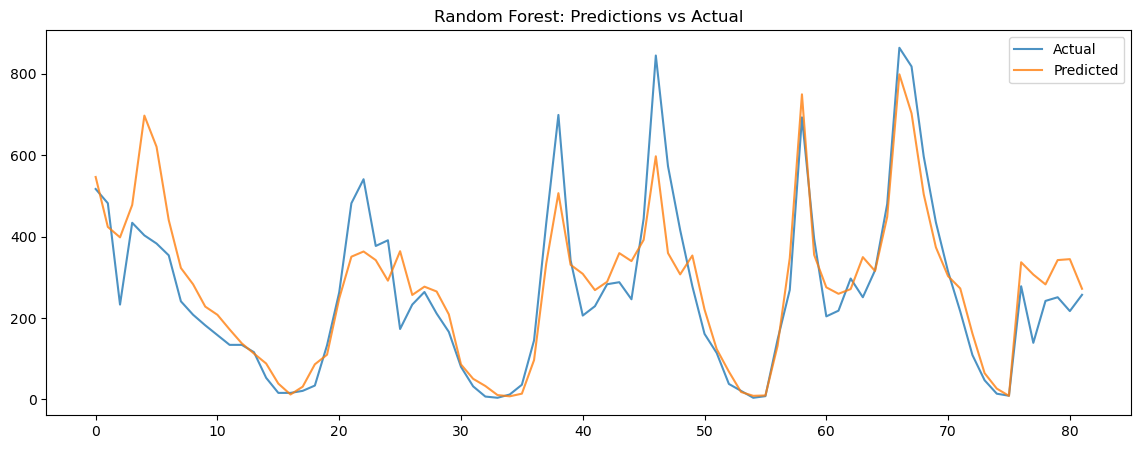

['outputs\\rf_final.joblib']

In [11]:
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RF Holdout -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

# Feature importance
feat_importances = pd.Series(rf.feature_importances_, index=features_final).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title('Feature Importances (RF)')
plt.tight_layout()
plt.show()

# Predictions vs Actual
plt.figure(figsize=(14,5))
plt.plot(y_test.reset_index(drop=True).values[:500], label='Actual', alpha=0.8)
plt.plot(y_pred[:500], label='Predicted', alpha=0.8)
plt.title('Random Forest: Predictions vs Actual')
plt.legend()
plt.show()

# Save model
joblib.dump(rf, os.path.join(OUT_DIR,'rf_final.joblib'))

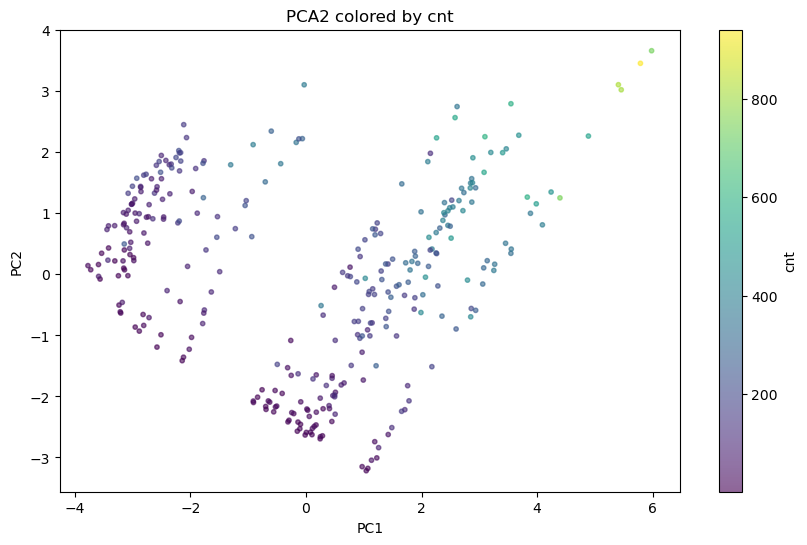

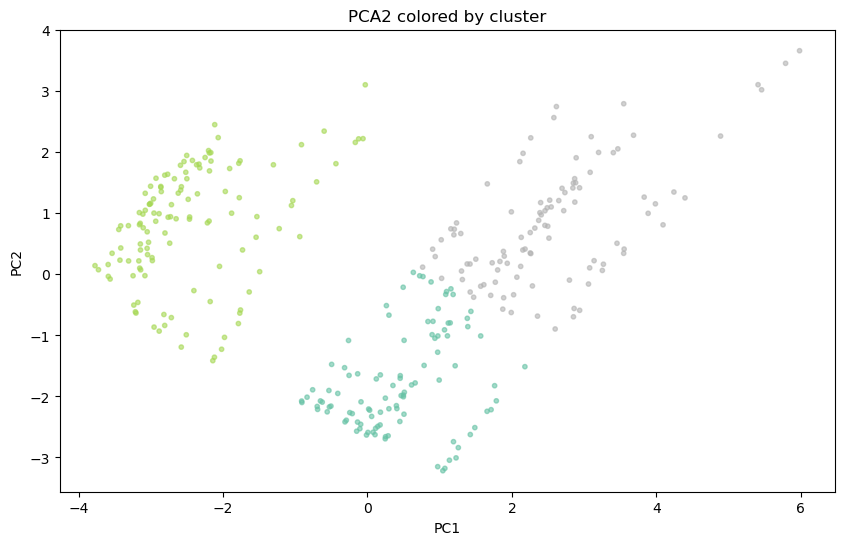

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=y_train, cmap='viridis', s=10, alpha=0.6)
plt.colorbar(label='cnt')
plt.title('PCA2 colored by cnt')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# PCA2 colored by cluster
plt.figure(figsize=(10,6))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=train_labels, cmap='Set2', s=10, alpha=0.6)
plt.title('PCA2 colored by cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Random Forest Regression Performance (Holdout/Test set):
RMSE: 88.504
MAE: 62.736
R2 score: 0.810


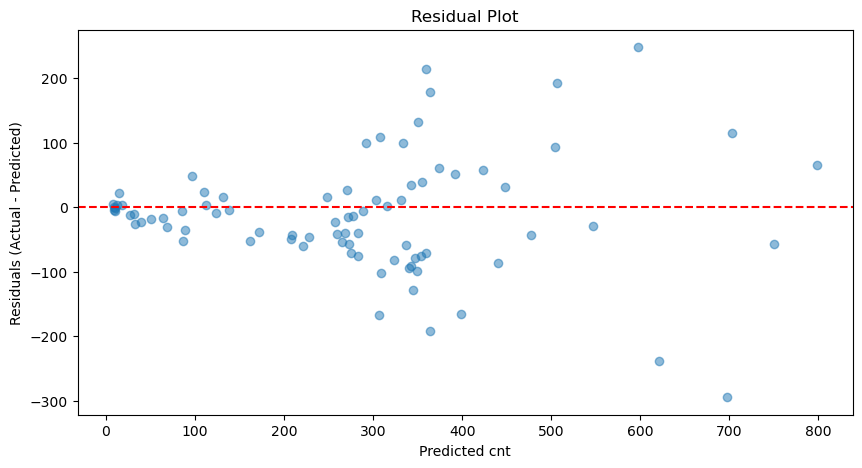

Top features by importance (Random Forest):


cnt_t_1            0.700828
cnt_t_168          0.136897
cnt_t_24           0.098127
hr_cos             0.018175
hr_sin             0.012675
temp_combined      0.009771
cnt_rolling_24h    0.009323
cnt_rolling_7d     0.008650
month_sin          0.002981
month_cos          0.001610
dtype: float64

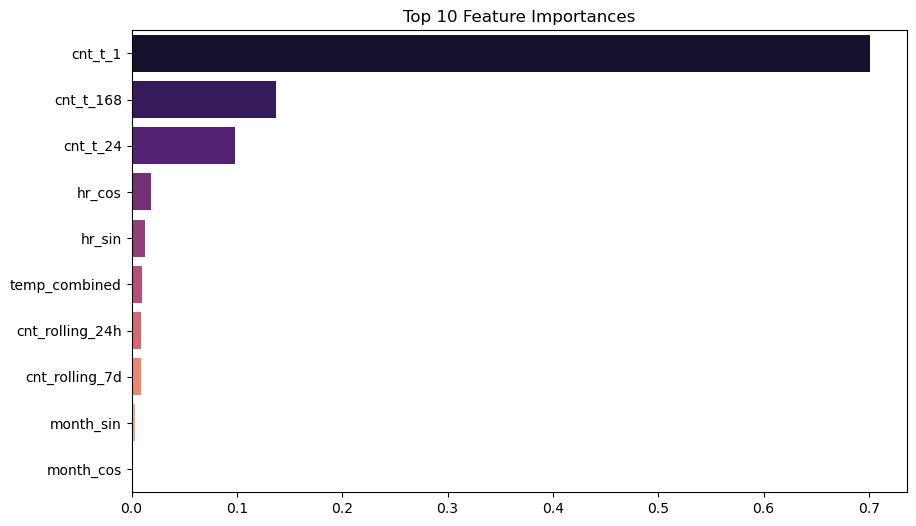

Optimal number of clusters (Silhouette): 3
Silhouette score for chosen k: 0.548
Cluster sizes (train):


0    102
1    124
2    102
dtype: int64

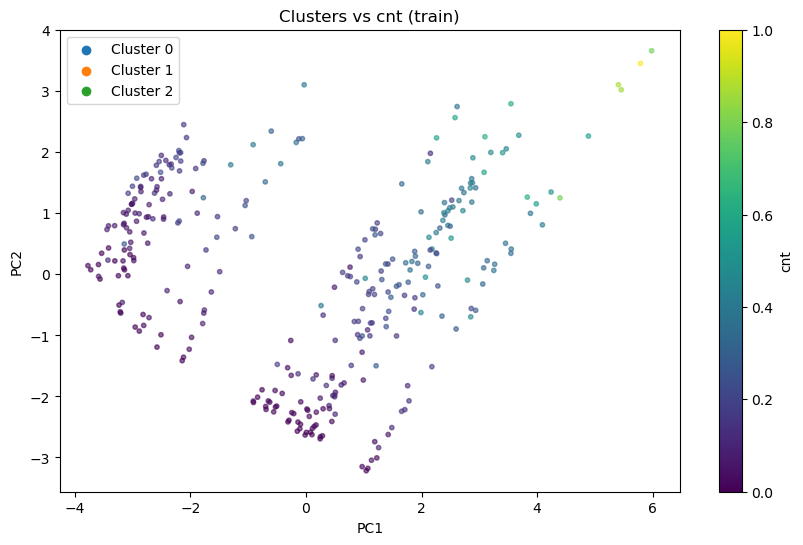

In [13]:
# ======================================================
# 6️⃣ Evaluation Phase
# ======================================================

# ---- 1. Regression model evaluation (RF) ----
print("Random Forest Regression Performance (Holdout/Test set):")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 score: {r2:.3f}")

# Residual analysis
residuals = y_test.values - y_pred
plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted cnt')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

# ---- 2. Feature importance evaluation ----
print("Top features by importance (Random Forest):")
display(feat_importances.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values[:10], y=feat_importances.index[:10], palette='magma')
plt.title('Top 10 Feature Importances')
plt.show()

# ---- 3. Clustering evaluation ----
print(f"Optimal number of clusters (Silhouette): {k_opt}")
sil_score = silhouette_score(X_train_pca2, train_labels)
print(f"Silhouette score for chosen k: {sil_score:.3f}")

# Cluster distribution
cluster_counts = pd.Series(train_labels).value_counts().sort_index()
print("Cluster sizes (train):")
display(cluster_counts)

# Visualize clusters vs target
plt.figure(figsize=(10,6))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=y_train, cmap='viridis', s=10, alpha=0.6)
for c in range(k_opt):
    plt.scatter([], [], c='C'+str(c), label=f'Cluster {c}')
plt.title('Clusters vs cnt (train)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='cnt')
plt.legend()
plt.show()